# Image Analysis Test 2

## Importing Libaries

In [1]:
import numpy as np # NumPy Library
import pandas as pd # Pandas Library
import os # Portable way of using operating system Dependent Funtions
import torch # Supports computations of tensor on GPUs
import torchvision # utilites for efficient Image and Video transformations
import matplotlib.pyplot as plt # Plotting library used for 2D graphics
import torch.nn as nn # contains different classess, help us to build Neural Networks
import torch.nn.functional as F # contains useful functions like convolution operations
import torchvision.transforms as tt # Transforms module provides various image transformations
from torchvision.transforms import ToTensor # Converts PIL image pixel range of [0,255] to FloatTensor range[0.0 , 1.0]
from torchvision.utils import make_grid # returns a tensor which contains the grid of images
from torchvision.datasets import ImageFolder # Generic data loader where images are arranged 
from torch.utils.data.dataloader import DataLoader # wraps an Iterable around the Dataset to enable easy access to the samples
from torch.utils.data import random_split # Randomly split a dataset non-overlapping new datasets of given lengths
%matplotlib inline
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
train = ImageFolder(r"D:\Image_Analysis\Image_Analysis\Image Data\archive\seg_train", transform = tt.Compose([tt.Resize(64), tt.RandomCrop(64), tt.ToTensor()]))
train_dl = DataLoader(train, 64, shuffle=True, num_workers=3, pin_memory=True)

def get_mean_std(dl):

    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1
    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean, std
mean, std = get_mean_std(train_dl)
mean, std


(tensor([0.4303, 0.4576, 0.4538]), tensor([0.2480, 0.2467, 0.2806]))

In [3]:
stats = ((0.4303, 0.4576, 0.4538),(0.2480, 0.2467, 0.2806))
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

In [4]:
train = ImageFolder(r"D:\Image_Analysis\Image_Analysis\Image Data\archive\seg_train", transform = train_transform)
test = ImageFolder(r"D:\Image_Analysis\Image_Analysis\Image Data\archive\seg_test", transform = test_transform)

In [5]:
random_seed = 42
torch.manual_seed(random_seed)

In [6]:
val_size = int(len(train)*0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(11228, 2806)

In [7]:
batch_size = 128

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

In [8]:
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1,3,1,1)
    stds = torch.tensor(stds).reshape(1,3,1,1)
    return images * stds + means

def  show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(24,24))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow=8).permute(1,2,0).clamp(0,1))
        break

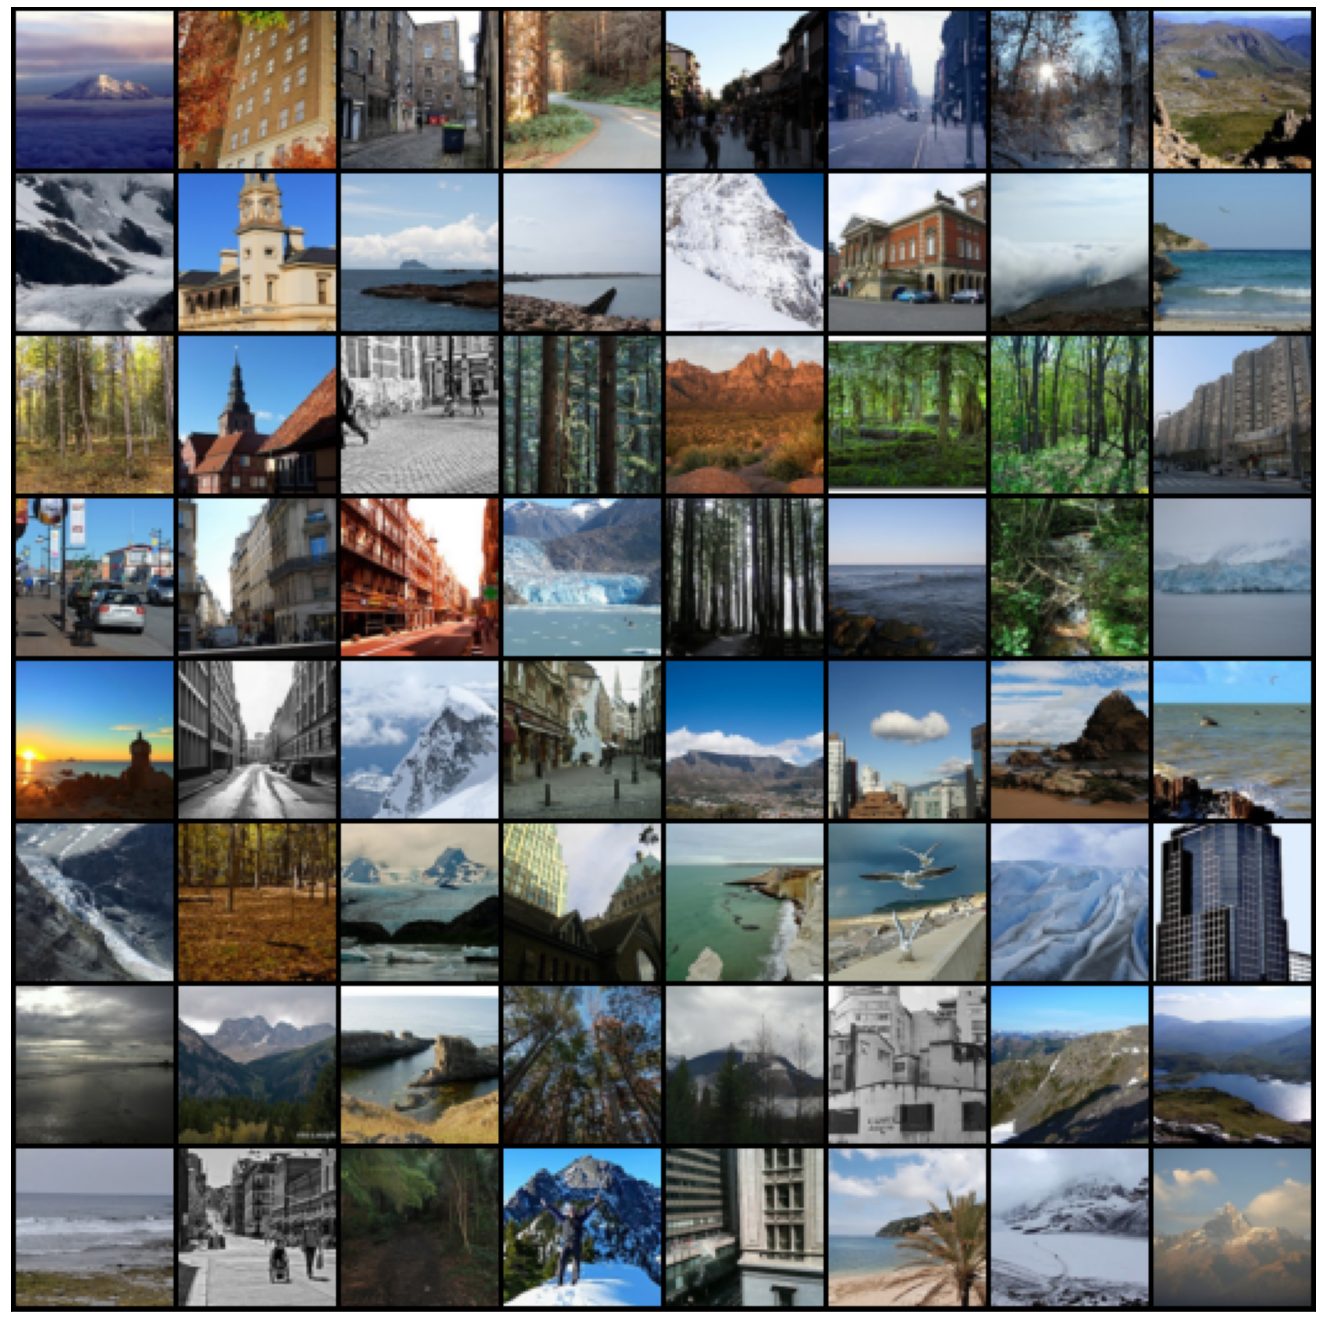

In [9]:
show_batch(train_dl)

In [10]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [13]:
device = get_default_device()
device

device(type='cpu')

In [1]:
import tensorflow as tf
tf.test.is_gpu_available()

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x000001AEB30E53B8> returned a result with an error set